In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'http://www.anefian.com/research/gt_db.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall('/content/datasets/face_images')

# Process Dataset

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import cv2
import os
import glob
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
  images = []
  for filename in os.listdir(folder):
    if os.path.isdir(folder + filename):
      images.extend(load_images_from_folder(folder + filename))
    else:
      img = cv2.imread(os.path.join(folder, filename))
      if img is not None:
        images.append(img)
  return images

In [ ]:
img_size = 128
img_dir = "/content/datasets/face_images/gt_db/"
images = load_images_from_folder(img_dir)

Resize images, normalize them, and put them into a numpy array

In [ ]:
np_images = np.zeros((len(images), img_size, img_size, 3))
for i in range(len(images)):
  np_images[i] = cv2.cvtColor(cv2.resize(images[i], (img_size, img_size)), cv2.COLOR_BGR2RGB) / 255.0

In [ ]:
img_count = np_images.shape[0]
train_test_split = 0.8

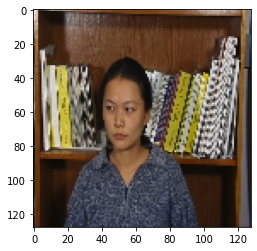

In [ ]:
plt.imshow(np_images[0])

Augment dataset

In [ ]:
import random
def fill(img, h, w):
  img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
  return img

def zoom(img, value):
  value = random.uniform(value, 1)
  h, w = img.shape[:2]
  h_taken = int(value*h)
  w_taken = int(value*w)
  h_start = random.randint(0, h-h_taken)
  w_start = random.randint(0, w-w_taken)
  img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
  img = fill(img, h, w)
  return img

def vertical_shift(img, ratio=0.0):
  if ratio > 1 or ratio < 0:
      print('Value should be less than 1 and greater than 0')
      return img
  ratio = random.uniform(-ratio, ratio)
  h, w = img.shape[:2]
  to_shift = h*ratio
  if ratio > 0:
      img = img[:int(h-to_shift), :, :]
  if ratio < 0:
      img = img[int(-1*to_shift):, :, :]
  img = fill(img, h, w)
  return img

def horizontal_shift(img, ratio=0.0):
  if ratio > 1 or ratio < 0:
      print('Value should be less than 1 and greater than 0')
      return img
  ratio = random.uniform(-ratio, ratio)
  h, w = img.shape[:2]
  to_shift = h*ratio
  if ratio > 0:
      img = img[:, :int(h-to_shift), :]
  if ratio < 0:
      img = img[:, int(-1*to_shift):, :]
  img = fill(img, h, w)
  return img

def scale_rgb(img):
  h, w, c = img.shape
  scale = float(random.randrange(60,100))/100
  for i in range(h):
      for j in range(w):
          for k in range(c):
              img[i][j][k] = img[i][j][k]*scale
  return img

In [ ]:
test_train_split = .9
augmented_images = np.zeros((int(len(images)*9*test_train_split), img_size, img_size, 3))
for i in range(int(len(images)*test_train_split)):
  augmented_images[i*9+0] = np_images[i]
  augmented_images[i*9+1] = cv2.flip(np_images[i], 0) #Vertical flip
  augmented_images[i*9+2] = cv2.flip(np_images[i], 1) #Horizontal flip
  augmented_images[i*9+3] = zoom(np_images[i], .5) #Zoom (crop)
  augmented_images[i*9+4] = vertical_shift(np_images[i], .5) #Vertical shift
  augmented_images[i*9+5] = zoom(vertical_shift(np_images[i], .5), .5) #Vertical shift + zoom
  augmented_images[i*9+6] = zoom(horizontal_shift(np_images[i], .5), .5) #Vertical shift + zoom
  augmented_images[i*9+7] = cv2.flip(zoom(vertical_shift(np_images[i], .5), .5), 1) #Vertical shift + zoom + horizontal flip
  augmented_images[i*9+8] = scale_rgb(np_images[i])

In [ ]:
np.random.shuffle(augmented_images)

In [ ]:
test_images = np.copy(np_images[int(test_train_split*len(images)):])

In [ ]:
test_images.shape

(75, 128, 128, 3)

In [ ]:
augmented_images.shape

(6075, 128, 128, 3)

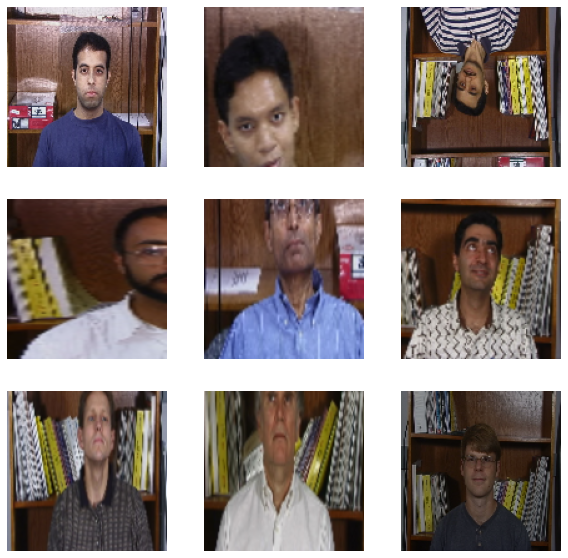

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[i+10])
  plt.axis("off")

Save augmented dataset

In [ ]:
!mkdir /content/datasets/face_images/augmented
!mkdir /content/datasets/face_images/l_images
!mkdir /content/datasets/face_images/a_images
!mkdir /content/datasets/face_images/b_images
!mkdir /content/datasets/face_images/test

In [ ]:
for i in range(augmented_images.shape[0]):
  cv2.imwrite("/content/datasets/face_images/augmented/img_" + str(i) + ".jpg", augmented_images[i]*255)

In [ ]:
for i in range(test_images.shape[0]):
  cv2.imwrite("/content/datasets/face_images/test/img_" + str(i) + ".jpg", test_images[i]*255)

Zip folder for future usage

In [ ]:
!zip -r augmented.zip /content/datasets/face_images/augmented

Convert to lab

In [ ]:
def convert_dir(dir):
  num_files = len(list(os.listdir(dir)))
  l_images = np.zeros((num_files, img_size, img_size))
  a_images = np.zeros((num_files, img_size, img_size))
  b_images = np.zeros((num_files, img_size, img_size))
  i = 0
  for file in os.listdir(dir):
    temp_img = np.float32(cv2.imread(dir + file))/255.0
    lab_image = cv2.cvtColor(temp_img, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab_image)
    l_images[i] = l
    a_images[i] = a
    b_images[i] = b
    i += 1
  return l_images, a_images, b_images

In [ ]:
l_images, a_images, b_images = convert_dir("/content/datasets/face_images/augmented/")
test_l, test_a, test_b = convert_dir("/content/datasets/face_images/test/")

In [ ]:
test_l.shape

(75, 128, 128)

In [ ]:
l_images.shape

(6075, 128, 128)

In [ ]:
%reset_selective augmented_images
%reset_selective images
%reset_selective np_images

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.


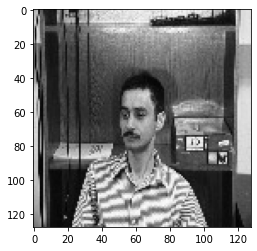

In [ ]:
plt.imshow(l_images[0], cmap="gray")

Save each channel to its own folder and zip them for submission

In [ ]:
for i in range(augmented_images.shape[0]):
  cv2.imwrite("/content/datasets/face_images/l_images/img_" + str(i) + ".jpg", l_images[i])
  cv2.imwrite("/content/datasets/face_images/a_images/img_" + str(i) + ".jpg", a_images[i])
  cv2.imwrite("/content/datasets/face_images/b_images/img_" + str(i) + ".jpg", b_images[i])

In [ ]:
!zip -r l_images.zip /content/datasets/face_images/l_images
!zip -r a_images.zip /content/datasets/face_images/a_images
!zip -r b_images.zip /content/datasets/face_images/b_images

# Train Simple Regressor

## Prepare training data

In [1]:
def get_mean_chrominance(img1, img2, is_sigmoid=True):
  if is_sigmoid:
    return (np.mean((img1+86.185)/184.439), np.mean((img2+107.863)/202.345))
  else:
    return (np.mean((img1)/184.439), np.mean((img2)/202.345))

In [2]:
def normalize_chroma(img1, img2, is_sigmoid=True, is_normalize=True):
  y_data = np.zeros((img_size, img_size, 2))
  if is_normalize:
    a_s = (img1+(86.185 if is_sigmoid else 0))/184.439
    b_s = (img2+(107.863 if is_sigmoid else 0))/202.345
  else:
    a_s = img1
    b_s = img2
  for x in range(img_size):
    for y in range(img_size):
      y_data[x,y,0] = a_s[x,y]
      y_data[x,y,1] = b_s[x,y]
  return y_data

In [ ]:
sample_count = l_images.shape[0]
x = l_images / 100.0
y = np.array([get_mean_chrominance(a_images[x], b_images[x]) for x in range(sample_count)])

In [ ]:
print(x.shape)
print(y.shape)

In [ ]:
train_test_split = .8
x_train = x[:int(train_test_split*sample_count)]
x_test = x[int(train_test_split*sample_count):]

y_train = y[:int(train_test_split*sample_count)]
y_test = y[int(train_test_split*sample_count):]

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
print(np.max(x_train))
print(np.min(x_train))
print(np.max(y_train))
print(np.min(y_train))

## Define Model

In [ ]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(3, (3,3), strides=(2,2), padding="same", activation="relu", input_shape=(img_size,img_size,1)))
  model.add(tf.keras.layers.Conv2D(3, (3,3), strides=(2,2), padding="same", activation="relu"))
  model.add(tf.keras.layers.Conv2D(3, (3,3), strides=(2,2), padding="same", activation="relu"))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(2, activation="sigmoid"))
  model.compile(
      optimizer='adam',
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=['mse']
  )
  return model

In [ ]:
mean_chroma_model = create_model()
mean_chroma_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 64, 64, 3)         30        
                                                                 
 conv2d_73 (Conv2D)          (None, 32, 32, 3)         84        
                                                                 
 conv2d_74 (Conv2D)          (None, 16, 16, 3)         84        
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1538      
                                                                 
Total params: 1,736
Trainable params: 1,736
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mean_chroma_model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
122/122 [==============================] - 2s 9ms/step - loss: 8.1121e-04 - mse: 8.1121e-04 - val_loss: 5.8345e-04 - val_mse: 5.8345e-04
Epoch 2/10
122/122 [==============================] - 1s 7ms/step - loss: 5.4784e-04 - mse: 5.4784e-04 - val_loss: 5.3360e-04 - val_mse: 5.3360e-04
Epoch 3/10
122/122 [==============================] - 1s 7ms/step - loss: 5.0134e-04 - mse: 5.0134e-04 - val_loss: 4.9143e-04 - val_mse: 4.9143e-04
Epoch 4/10
122/122 [==============================] - 1s 6ms/step - loss: 4.5762e-04 - mse: 4.5762e-04 - val_loss: 4.8832e-04 - val_mse: 4.8832e-04
Epoch 5/10
122/122 [==============================] - 1s 6ms/step - loss: 4.3743e-04 - mse: 4.3743e-04 - val_loss: 4.5531e-04 - val_mse: 4.5531e-04
Epoch 6/10
122/122 [==============================] - 1s 6ms/step - loss: 4.1465e-04 - mse: 4.1465e-04 - val_loss: 4.3095e-04 - val_mse: 4.3095e-04
Epoch 7/10
122/122 [==============================] - 1s 6ms/step - loss: 3.9516e-04 - mse: 3.9516e-04 - val_los

In [ ]:
mean_chroma_model.evaluate(x_test, y_test)

38/38 [==============================] - 0s 3ms/step - loss: 3.9517e-04 - mse: 3.9517e-04


[0.00039517393452115357, 0.00039517393452115357]

# Colorization

In [ ]:
sample_count = l_images.shape[0]
x = np.float32(l_images / 100.0)
y = np.float32(np.array([normalize_chroma(a_images[x], b_images[x], is_sigmoid=True) for x in range(sample_count)]))

In [ ]:
print(x.shape)
print(y.shape)

(5250, 128, 128)
(5250, 128, 128, 2)


In [ ]:
train_test_split = .9
x_train = x
y_train = y
x_test = np.float32(test_l / 100.0)
y_test = np.float32(np.array([normalize_chroma(test_a[x], test_b[x], is_sigmoid=True) for x in range(test_l.shape[0])]))

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6075, 128, 128)
(75, 128, 128)
(6075, 128, 128, 2)
(75, 128, 128, 2)


In [ ]:
print(np.max(x_train))
print(np.min(x_train))
print(np.max(y_train))
print(np.min(y_train))

0.9700928
0.0
0.36725643
-0.3199208


In [ ]:
def create_colorizer_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=(img_size,img_size,1)))
  model.add(tf.keras.layers.Conv2D(64, (3,3), strides=2, padding="same", activation="relu"))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(64, (3,3), strides=2, padding="same", activation="relu"))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(64, (3,3), strides=2, padding="same", activation="relu"))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation="relu"))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation="relu"))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation="relu"))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same"))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same"))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same"))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(2, kernel_size=(3,3), activation="sigmoid", padding="same"))#Change to activation to tanh to check for extra credit
  model.add(tf.keras.layers.Reshape((128,128,2)))

  model.compile(
      optimizer='adam',
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mae']
  )
  return model

In [ ]:
chroma_model = create_colorizer_model()
chroma_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_43 (Bat  (None, 128, 128, 1)      4         
 chNormalization)                                                
                                                                 
 conv2d_159 (Conv2D)         (None, 64, 64, 64)        640       
                                                                 
 conv2d_160 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 conv2d_161 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 conv2d_162 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 conv2d_163 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

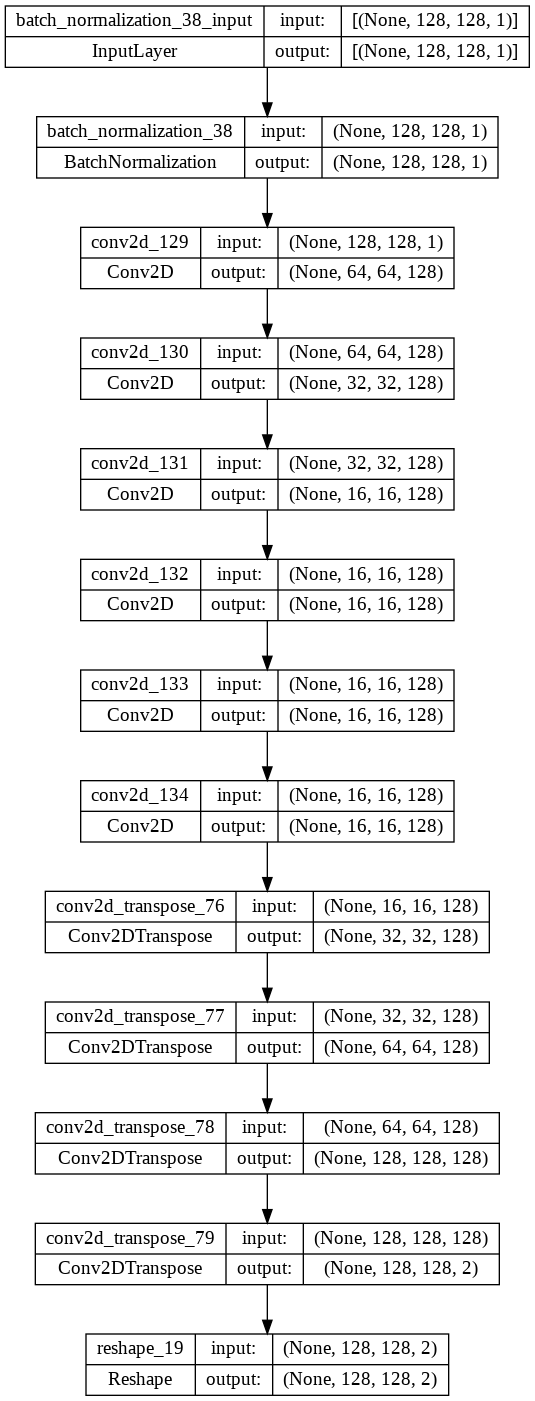

In [ ]:
tf.keras.utils.plot_model(chroma_model, show_shapes=True)

In [ ]:
history = chroma_model.fit(
    x=x_train, 
    y=y_train,
    epochs=10,
    batch_size=20,
    validation_split=0.25
)

Epoch 1/10
228/228 [==============================] - 10s 38ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0384 - val_mae: 0.0384
Epoch 2/10
228/228 [==============================] - 8s 37ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0261 - val_mae: 0.0261
Epoch 3/10
228/228 [==============================] - 8s 37ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 4/10
228/228 [==============================] - 9s 37ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0219 - val_mae: 0.0219
Epoch 5/10
228/228 [==============================] - 9s 38ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0208 - val_mae: 0.0208
Epoch 6/10
228/228 [==============================] - 9s 38ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0194 - val_mae: 0.0194
Epoch 7/10
228/228 [==============================] - 9s 38ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0188 - val_mae: 0.0188
Epoch 8/10
228/228 [==============================] - 9s 39ms/step -

In [ ]:
!nvidia-smi

Mon Oct 31 23:26:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    34W /  70W |  14632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

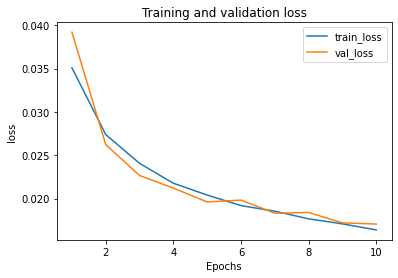

In [ ]:
plot_metric(history, 'loss')

## Look at Results

In [ ]:
chroma_model.evaluate(x_test, y_test, verbose=2)

3/3 - 0s - loss: 0.0171 - mae: 0.0171 - 96ms/epoch - 32ms/step


[0.01709873601794243, 0.01709873601794243]

In [ ]:
y_pred = chroma_model.predict(x_test)

3/3 [==============================] - 0s 31ms/step


<Figure size 1080x1080 with 0 Axes>

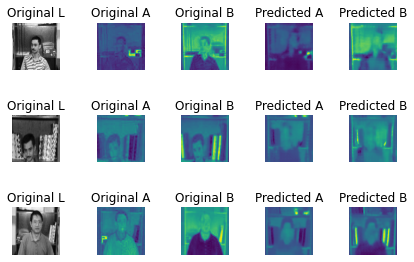

In [ ]:
plt.figure(figsize=(15, 15))
f, axarr = plt.subplots(3, 5)
f.tight_layout()
for i in range(3):
  
  axarr[i,0].imshow(x_train[i], cmap="gray")
  axarr[i,0].set_title("Original L")
  axarr[i,1].imshow(np.split(y_train[i], 2, axis=2)[0].reshape((img_size, img_size)))
  axarr[i,1].set_title("Original A")
  axarr[i,2].imshow(np.split(y_train[i], 2, axis=2)[1].reshape((img_size, img_size)))
  axarr[i,2].set_title("Original B")
  axarr[i,3].imshow(np.split(y_pred[i], 2, axis=2)[0].reshape((img_size, img_size)))
  axarr[i,3].set_title("Predicted A")
  axarr[i,4].imshow(np.split(y_pred[i], 2, axis=2)[1].reshape((img_size, img_size)))
  axarr[i,4].set_title("Predicted B")
  axarr[i,0].axis('off')
  axarr[i,1].axis('off')
  axarr[i,2].axis('off')
  axarr[i,3].axis('off')
  axarr[i,4].axis('off')


In [ ]:
def denormalize_chroma(l, ab, is_sigmoid=True):
  y_data = np.zeros((img_size, img_size, 3))
  if is_sigmoid:
    a_s = (np.split(ab, 2, axis=2)[0])*184.439-86.185
    b_s = (np.split(ab, 2, axis=2)[1])*202.345-107.863
  else:
    a_s = (np.split(ab, 2, axis=2)[0])*184.439
    b_s = (np.split(ab, 2, axis=2)[1])*202.345
  l=l*100.0
  for x in range(img_size):
    for y in range(img_size):
      y_data[x,y,0] = l[x,y]
      y_data[x,y,1] = a_s[x,y]
      y_data[x,y,2] = b_s[x,y]
  return y_data

<Figure size 3600x3600 with 0 Axes>

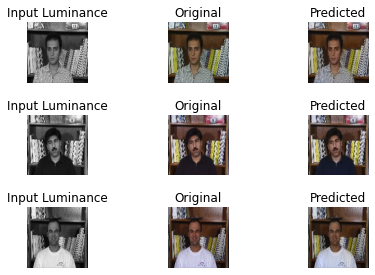

In [ ]:
plt.figure(figsize=(50, 50))
f, axarr = plt.subplots(3, 3)
f.tight_layout()
items = random.choices(range(x_test.shape[0]), k=3)
for i in range(3):
  axarr[i,0].imshow(x_test[items[i]], cmap="gray")
  axarr[i,0].set_title("Input Luminance")
  axarr[i,1].imshow(cv2.cvtColor(denormalize_chroma(x_test[items[i]], y_test[items[i]], is_sigmoid=True).astype('float32'), cv2.COLOR_LAB2RGB))
  axarr[i,1].set_title("Original")
  axarr[i,2].imshow(cv2.cvtColor(denormalize_chroma(x_test[items[i]], y_pred[items[i]], is_sigmoid=True).astype('float32'), cv2.COLOR_LAB2RGB))
  axarr[i,2].set_title("Predicted")
  axarr[i,0].axis('off')
  axarr[i,1].axis('off')
  axarr[i,2].axis('off')


# Transfer Learning

In [ ]:
!mkdir /content/datasets/ncd/colors/

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

with ZipFile("/content/ColorfulOriginal.zip") as zfile:
  zfile.extractall('/content/datasets/ncd/colors/')

with ZipFile("/content/NCDataset.zip") as zfile:
  zfile.extractall('/content/datasets/ncd/colors/')

## Prepare dataset

In [ ]:
img_dir = "/content/datasets/ncd/colors/ColorfulOriginal/"
color_images = load_images_from_folder(img_dir)

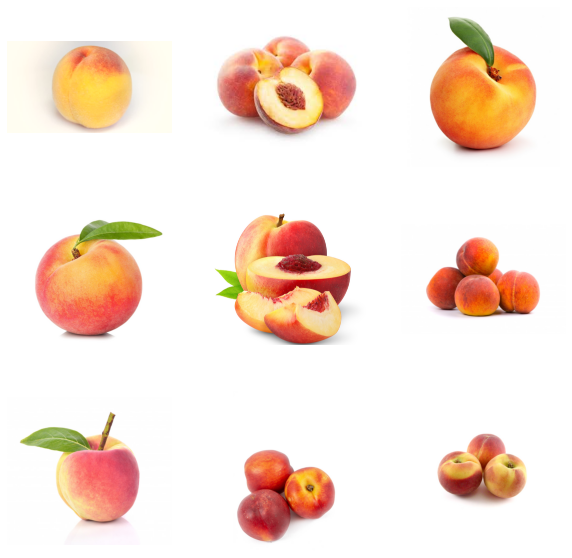

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(cv2.cvtColor(color_images[i+10], cv2.COLOR_BGR2RGB))
  plt.axis("off")

In [ ]:
l_ncd_images = np.zeros((len(color_images), img_size, img_size))
a_ncd_images = np.zeros((len(color_images), img_size, img_size))
b_ncd_images = np.zeros((len(color_images), img_size, img_size))
for i in range(len(color_images)):
  l, a, b = cv2.split(cv2.cvtColor(cv2.resize(color_images[i], (img_size, img_size)), cv2.COLOR_BGR2LAB) / 255.0)
  l_ncd_images[i] = l
  a_ncd_images[i] = a
  b_ncd_images[i] = b

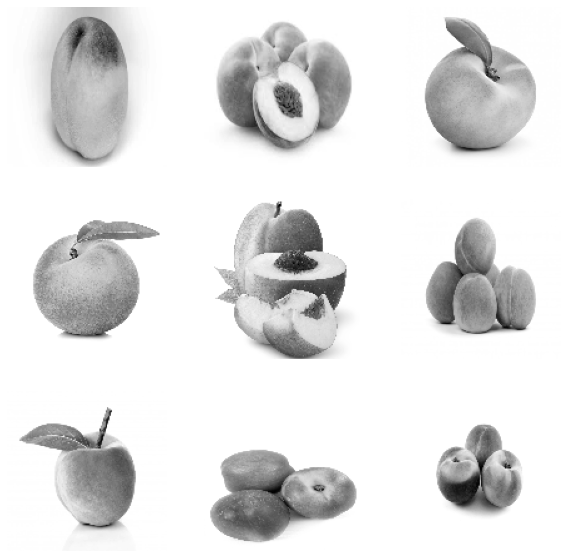

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(l_ncd_images[i+10], cmap="gray")
  plt.axis("off")

In [ ]:
x_ncd = l_ncd_images
y_ncd = np.float32(np.array([normalize_chroma(a_ncd_images[x], b_ncd_images[x], is_normalize=False) for x in range(x_ncd.shape[0])]))

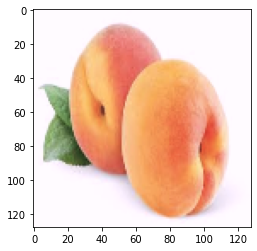

In [ ]:
plt.imshow(cv2.cvtColor(denormalize_chroma(x_ncd[0], y_ncd[0]).astype('float32'), cv2.COLOR_LAB2RGB))

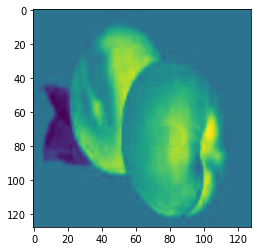

In [ ]:
plt.imshow(np.split(denormalize_chroma(x_ncd[0], y_ncd[0]).astype('float32'), 3, axis=2)[1].reshape(128,128))

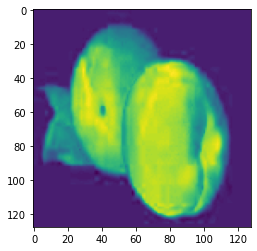

In [ ]:
plt.imshow(np.split(denormalize_chroma(x_ncd[0], y_ncd[0]).astype('float32'), 3, axis=2)[2].reshape(128,128))

In [ ]:
chroma_model.evaluate(x=x_ncd, y=y_ncd)

23/23 [==============================] - 1s 25ms/step - loss: 0.0590 - mae: 0.0590


[0.05899546295404434, 0.05899546295404434]

In [ ]:
ncd_pred = chroma_model.predict(x_ncd)

23/23 [==============================] - 1s 30ms/step


In [ ]:
np.min(y_ncd)

0.21176471

In [ ]:
np.max(y_ncd)

0.8666667

<Figure size 1080x1080 with 0 Axes>

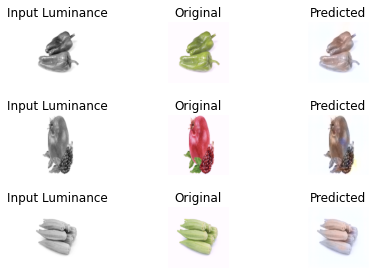

In [ ]:
plt.figure(figsize=(15, 15))
f, axarr = plt.subplots(3, 3)
f.tight_layout()
items = random.choices(range(x_ncd.shape[0]), k=3)
for i in range(3):
  axarr[i,0].imshow(x_ncd[items[i]], cmap="gray")
  axarr[i,0].set_title("Input Luminance")
  axarr[i,1].imshow(cv2.cvtColor(denormalize_chroma(x_ncd[items[i]], y_ncd[items[i]]).astype('float32'), cv2.COLOR_LAB2RGB))
  axarr[i,1].set_title("Original")
  axarr[i,2].imshow(cv2.cvtColor(denormalize_chroma(x_ncd[items[i]], ncd_pred[items[i]]).astype('float32'), cv2.COLOR_LAB2RGB))
  axarr[i,2].set_title("Predicted")
  axarr[i,0].axis('off')
  axarr[i,1].axis('off')
  axarr[i,2].axis('off')


In [ ]:
from google.colab import files
files.download("/content/l_images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>